# Social Circle Dataset EDA

Use this notebook to understand the `learning-social-circles` ego-network data (graphs plus circle labels) before modeling. Update the data path below, then run the cells to inspect structure, scale, and label coverage.

In [3]:
import os
from itertools import combinations, islice
from math import comb
from pathlib import Path

import networkx as nx
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)


## Locate the dataset

Set `BASE_DIR` to the root of the `learning-social-circles` download (it should contain `egonets/` and `Training/`). 

In [4]:
NOTEBOOK_DIR = Path.cwd().resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name.lower() == "eda" else NOTEBOOK_DIR

candidates = []
env_dir = os.getenv("SOCIAL_CIRCLE_DATA_DIR")
if env_dir:
    candidates.append(Path(env_dir).expanduser())

candidates += [
    PROJECT_ROOT / "data" / "learning-social-circles",
    PROJECT_ROOT / "datasets" / "learning-social-circles",
    PROJECT_ROOT.parent / "datasets" / "learning-social-circles",
    Path("/Users/sruzics/Downloads/learning-social-circles"),
]

BASE_DIR = next((p for p in candidates if p.is_dir()), None)
if BASE_DIR is None:
    BASE_DIR = Path("/path/to/learning-social-circles").expanduser()

EGONET_DIR = BASE_DIR / "egonets"
CIRCLES_DIR = BASE_DIR / "Training"

print(f"Notebook directory: {NOTEBOOK_DIR}")
print(f"Project root guess: {PROJECT_ROOT}")
print(f"Using BASE_DIR: {BASE_DIR}")
print(f"Egonet dir present? {EGONET_DIR.exists()}  Circles dir present? {CIRCLES_DIR.exists()}")

if not EGONET_DIR.exists() or not CIRCLES_DIR.exists():
    raise FileNotFoundError("Set BASE_DIR to the folder containing 'egonets' and 'Training' from the learning-social-circles dataset.")


Notebook directory: /Users/sruzics/Recommender-System-SocialCircle-1/EDA
Project root guess: /Users/sruzics/Recommender-System-SocialCircle-1
Using BASE_DIR: /Users/sruzics/Downloads/learning-social-circles
Egonet dir present? True  Circles dir present? True


## Peek at raw files

Check how many ego-networks and circle label files are available and inspect a sample to confirm the expected format.

In [5]:
def ids_from_dir(path: Path, suffix: str):
    ids = []
    for p in path.glob(f"*{suffix}"):
        try:
            ids.append(int(p.stem))
        except ValueError:
            continue
    return sorted(ids)


def peek(path: Path, n: int = 5):
    print(f"-- {path} --")
    with path.open("r") as f:
        for line in islice(f, n):
            print(line.rstrip())
    print()

ego_ids = ids_from_dir(EGONET_DIR, ".egonet")
circle_ids = ids_from_dir(CIRCLES_DIR, ".circles")
labeled_ego_ids = [eid for eid in ego_ids if eid in set(circle_ids)]

print(f"Egos with egonet file: {len(ego_ids)}")
print(f"Egos with circle labels: {len(circle_ids)}")
print(f"Egos we can analyze (graph + labels): {len(labeled_ego_ids)}")
print(f"Example ego IDs: {labeled_ego_ids[:8]}")

if labeled_ego_ids:
    sample_ego = labeled_ego_ids[0]
    peek(EGONET_DIR / f"{sample_ego}.egonet", n=5)
    peek(CIRCLES_DIR / f"{sample_ego}.circles", n=5)
else:
    print("No overlapping egonet/circle files found.")


Egos with egonet file: 110
Egos with circle labels: 60
Egos we can analyze (graph + labels): 60
Example ego IDs: [239, 345, 611, 1357, 1839, 1968, 2255, 2365]
-- /Users/sruzics/Downloads/learning-social-circles/egonets/239.egonet --
240: 283 241 334 285 309 310
241: 283 334 242 273 285 240 286 305 263 274 339 309 310 269
242: 283 241 273 285 286 305 263 274 339 269
243: 325 320 258 276 301 337 251 267 302 294 313 339 336 264 266
244: 252 328 340 257

-- /Users/sruzics/Downloads/learning-social-circles/Training/239.circles --
circle17: 306 281 311 247 342 315 297 303 304 343 333 296 250 255 331 248 340 265 322 289 344 287 326 249 324 307 290
circle16: 335 253 325 320 283 258 284 318 330 241 276 312 340 301 334 291 295 242 337 338 273 277 293 251 279 285 267 243 240 298 302 286 305 282 294 256 313 263 274 339 309 336 310 264 266 269
circle19: 280 308 254 246 270 314 299 329 261 271 327 259 317
circle18: 300 252 332 328 268 272 323 288 257 292 245 319 275 341 282 321 339 244 316



## Parsing helpers

Utilities to load an ego-network graph and the corresponding circle memberships (labelled positive pairs).

In [6]:
def load_egonet(ego_id: int, egonet_dir: Path = EGONET_DIR) -> nx.Graph:
    """Load a single ego-network as an undirected graph."""
    ego_file = egonet_dir / f"{ego_id}.egonet"
    if not ego_file.exists():
        raise FileNotFoundError(f"Missing egonet file: {ego_file}")

    G = nx.Graph()
    G.add_node(ego_id, is_ego=True)

    with ego_file.open("r") as f:
        for raw_line in f:
            line = raw_line.strip()
            if not line or ":" not in line:
                continue

            left, right = line.split(":", 1)
            u = int(left.strip())
            if u not in G:
                G.add_node(u, is_ego=False)
            G.add_edge(ego_id, u)

            neighbors_str = right.strip()
            if neighbors_str:
                for tok in neighbors_str.split():
                    v = int(tok)
                    if v not in G:
                        G.add_node(v, is_ego=False)
                    G.add_edge(u, v)

    return G


def load_circles(ego_id: int, circles_dir: Path = CIRCLES_DIR):
    """Load circles and derive positive labeled pairs for an ego."""
    circle_file = circles_dir / f"{ego_id}.circles"
    if not circle_file.exists():
        raise FileNotFoundError(f"Missing circle file: {circle_file}")

    circles = {}
    pair_labels = {}

    with circle_file.open("r") as f:
        for raw_line in f:
            line = raw_line.strip()
            if not line or ":" not in line:
                continue

            name_part, members_part = line.split(":", 1)
            circle_name = name_part.strip()
            members = {int(tok) for tok in members_part.strip().split()} if members_part.strip() else set()
            circles[circle_name] = members

            # mark positive pairs
            for u, v in combinations(sorted(members), 2):
                pair_labels[frozenset((u, v))] = 1

    return circles, pair_labels


## Dataset-level summary

Aggregate simple graph and label statistics across all egos that have both graph structure and circle annotations.

In [7]:
def summarize_ego(ego_id: int):
    G = load_egonet(ego_id)
    circles, pos_pairs = load_circles(ego_id)

    node_count = G.number_of_nodes()
    edge_count = G.number_of_edges()
    circle_sizes = [len(members) for members in circles.values()]
    member_pool = set().union(*circles.values()) if circles else set()

    total_pairs = comb(len(member_pool), 2) if len(member_pool) >= 2 else 0
    pos_pairs_count = len(pos_pairs)

    summary = {
        "ego_id": ego_id,
        "node_count": node_count,
        "edge_count": edge_count,
        "avg_degree": (2 * edge_count / node_count) if node_count else 0.0,
        "density": nx.density(G) if node_count > 1 else 0.0,
        "avg_clustering": nx.average_clustering(G) if node_count > 1 else 0.0,
        "circle_count": len(circles),
        "circle_min_size": int(np.min(circle_sizes)) if circle_sizes else 0,
        "circle_median_size": float(np.median(circle_sizes)) if circle_sizes else 0.0,
        "circle_max_size": int(np.max(circle_sizes)) if circle_sizes else 0,
        "positive_pairs": pos_pairs_count,
        "total_pairs": total_pairs,
        "positive_ratio": (pos_pairs_count / total_pairs) if total_pairs else 0.0,
    }

    return summary


summary_df = pd.DataFrame([summarize_ego(eid) for eid in labeled_ego_ids])
summary_df = summary_df.sort_values("ego_id").reset_index(drop=True)

print(f"Summary shape: {summary_df.shape}")
display(summary_df.head(10))
display(summary_df.describe(include="all").transpose())


Summary shape: (60, 13)


,ego_id,node_count,edge_count,avg_degree,density,avg_clustering,circle_count,circle_min_size,circle_median_size,circle_max_size,positive_pairs,total_pairs,positive_ratio
0,239,106,447,8.433962,0.080323,0.782560,4,13,23.0,46,1634,5151,0.317220
1,345,266,6450,48.496241,0.183005,0.643479,7,6,27.0,145,12410,31375,0.395538
2,611,239,2527,21.146444,0.088851,0.692337,10,8,20.0,108,8135,27966,0.290889
3,1357,456,6002,26.324561,0.057856,0.575223,10,7,10.0,64,2996,8128,0.368602
4,1839,129,939,14.558140,0.113735,0.674609,8,5,27.5,54,2710,6903,0.392583
5,1968,287,2607,18.167247,0.063522,0.674213,14,6,11.5,85,8344,36585,0.228072
6,2255,110,1319,23.981818,0.220017,0.796522,3,6,51.0,93,4293,4851,0.884972
7,2365,108,653,12.092593,0.113015,0.749855,10,5,12.0,36,1345,5050,0.266337
8,2738,52,102,3.923077,0.076923,0.637186,4,5,6.5,7,67,300,0.223333
9,2790,105,770,14.666667,0.141026,0.656651,8,5,10.0,54,1505,2080,0.723558


,count,mean,std,min,25%,50%,75%,max
ego_id,60.0,12072.183333,8263.743229,239.000000,5116.250000,10662.000000,18139.500000,27022.000000
node_count,60.0,242.983333,151.863843,46.000000,117.500000,220.000000,323.000000,671.000000
edge_count,60.0,3143.083333,4008.312677,102.000000,819.000000,1845.000000,3945.500000,25368.000000
avg_degree,60.0,20.862913,14.116545,3.923077,11.532826,16.690783,26.470273,95.368421
density,60.0,0.101502,0.051642,0.022288,0.063362,0.086350,0.120432,0.221980
avg_clustering,60.0,0.693178,0.060967,0.512657,0.655168,0.689030,0.737273,0.827022
circle_count,60.0,9.866667,5.558523,3.000000,5.000000,9.000000,12.250000,28.000000
circle_min_size,60.0,6.750000,3.985673,5.000000,5.000000,5.000000,6.000000,30.000000
circle_median_size,60.0,17.633333,9.684807,5.000000,11.000000,16.250000,21.625000,51.000000
circle_max_size,60.0,87.166667,66.359618,7.000000,45.250000,70.500000,109.500000,335.000000


## Distributions

Visual look at scale and label coverage per ego.

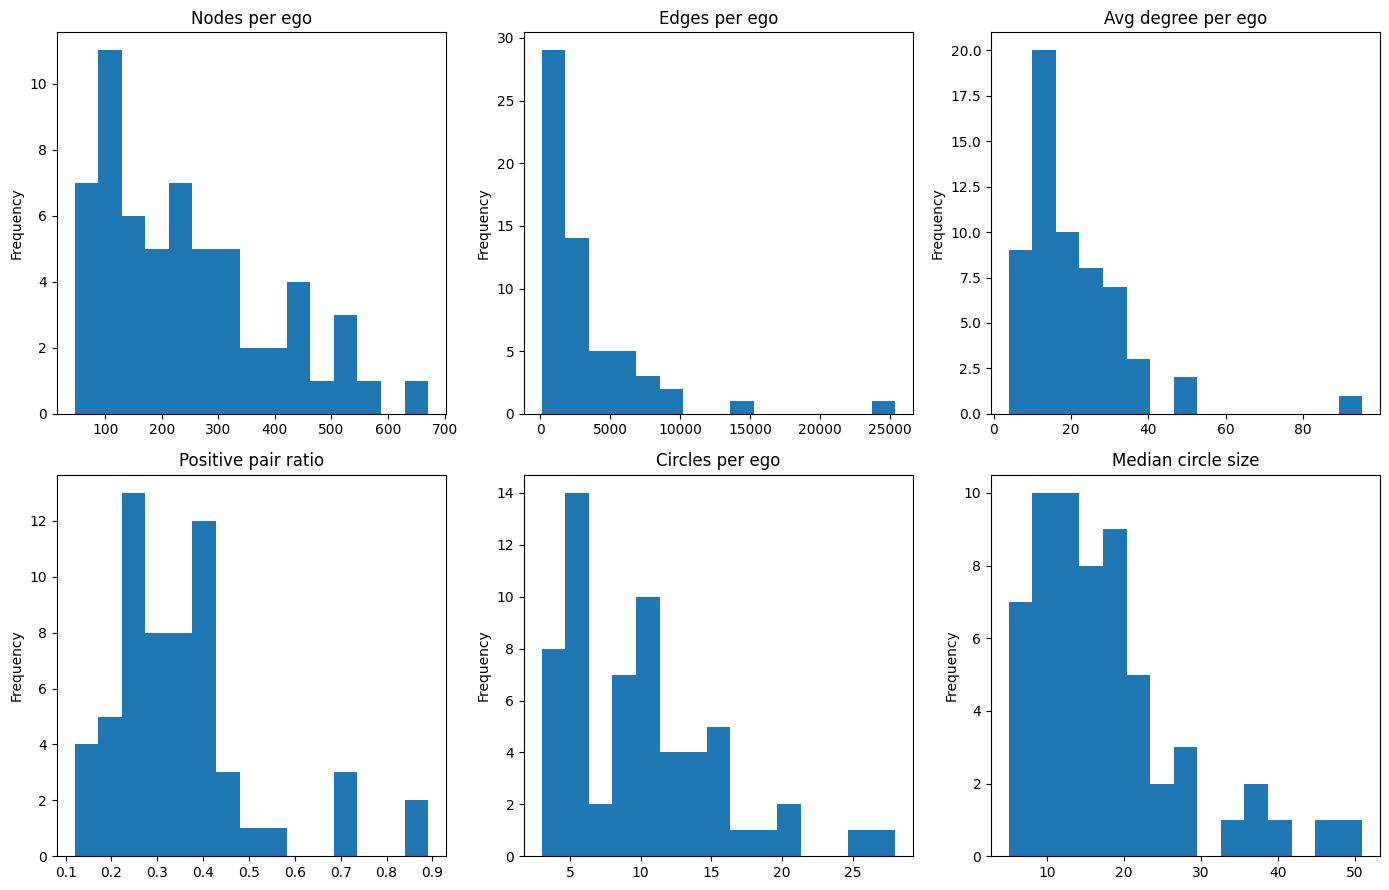

In [8]:
if  not summary_df.empty:
    fig, axes = plt.subplots(2, 3, figsize=(14, 9))

    summary_df["node_count"].plot(kind="hist", bins=15, ax=axes[0, 0], title="Nodes per ego")
    summary_df["edge_count"].plot(kind="hist", bins=15, ax=axes[0, 1], title="Edges per ego")
    summary_df["avg_degree"].plot(kind="hist", bins=15, ax=axes[0, 2], title="Avg degree per ego")

    summary_df["positive_ratio"].plot(kind="hist", bins=15, ax=axes[1, 0], title="Positive pair ratio")
    summary_df["circle_count"].plot(kind="hist", bins=15, ax=axes[1, 1], title="Circles per ego")
    summary_df["circle_median_size"].plot(kind="hist", bins=15, ax=axes[1, 2], title="Median circle size")

    plt.tight_layout()
else:
    print("No plots rendered; either summary_df is empty or matplotlib/seaborn is unavailable.")


## Dive into a single ego

Inspect degree distribution, circle sizes, and circle overlaps for a representative ego (picked as the one with the most circles).

Inspecting ego 4406
Nodes: 423  Edges: 3834  Density: 0.0430
Circles: 28  Median circle size: 16.5
Positive labeled pairs: 60860 / 88831 possible (68.51% if total_pairs else 0)%

Non-empty circle overlaps (top 10):


,ego_id,circle_a,circle_b,overlap,jaccard
31,4406,circle400,circle18,162,0.435484
16,4406,circle400,circle25,74,0.242623
17,4406,circle400,circle419,60,0.194805
74,4406,circle419,circle18,48,0.195122
14,4406,circle400,circle405,41,0.134868
42,4406,circle403,circle18,33,0.135802
56,4406,circle405,circle18,32,0.133891
48,4406,circle402,circle18,28,0.118143
13,4406,circle400,circle402,26,0.083067
43,4406,circle402,circle405,24,0.461538


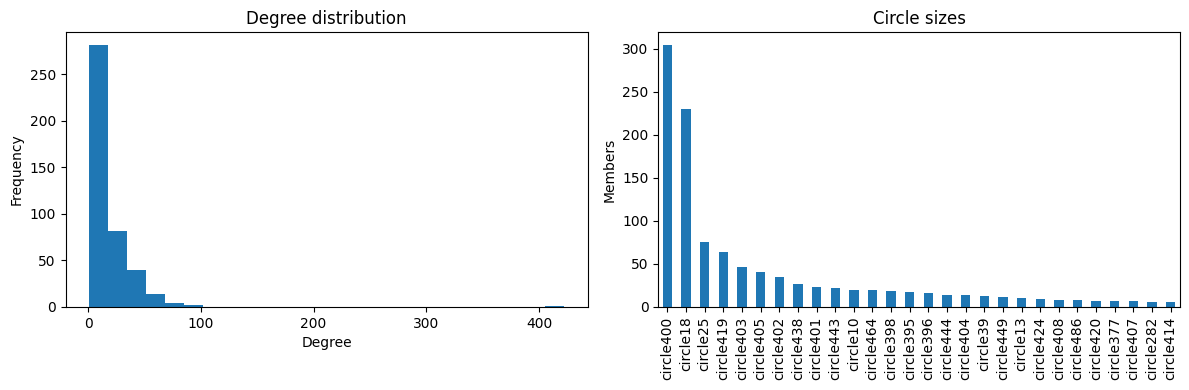

In [10]:
if summary_df.empty:
    print("Nothing to inspect; summary_df is empty.")
else:
    focus_ego = int(summary_df.sort_values("circle_count", ascending=False).iloc[0]["ego_id"])
    print(f"Inspecting ego {focus_ego}")

    G_focus = load_egonet(focus_ego)
    circles_focus, pos_pairs_focus = load_circles(focus_ego)

    deg_series = pd.Series(dict(G_focus.degree()))
    circle_sizes = pd.Series({name: len(members) for name, members in circles_focus.items()}).sort_values(ascending=False)

    member_pool = set().union(*circles_focus.values()) if circles_focus else set()
    total_pairs = comb(len(member_pool), 2) if len(member_pool) >= 2 else 0
    pos_pairs_count = len(pos_pairs_focus)

    print(f"Nodes: {G_focus.number_of_nodes()}  Edges: {G_focus.number_of_edges()}  Density: {nx.density(G_focus):.4f}")
    print(f"Circles: {len(circles_focus)}  Median circle size: {circle_sizes.median() if not circle_sizes.empty else 0}")
    print(f"Positive labeled pairs: {pos_pairs_count} / {total_pairs} possible ({(pos_pairs_count / total_pairs * 100):.2f}% if total_pairs else 0)%")

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    deg_series.plot(kind="hist", bins=25, ax=axes[0], title="Degree distribution")
    axes[0].set_xlabel("Degree")

    if not circle_sizes.empty:
        circle_sizes.plot(kind="bar", ax=axes[1], title="Circle sizes")
        axes[1].set_ylabel("Members")
    else:
        axes[1].set_visible(False)

    plt.tight_layout()

    overlap_rows = []
    for (name_a, members_a), (name_b, members_b) in combinations(circles_focus.items(), 2):
        overlap = len(members_a & members_b)
        if overlap:
            union = len(members_a | members_b)
            overlap_rows.append({
                "ego_id": focus_ego,
                "circle_a": name_a,
                "circle_b": name_b,
                "overlap": overlap,
                "jaccard": (overlap / union) if union else 0.0,
            })

    overlap_df = pd.DataFrame(overlap_rows).sort_values(by="overlap", ascending=False)
    print("\nNon-empty circle overlaps (top 10):")
    display(overlap_df.head(10))
